In [1]:
# Codeblock 1
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
# Codeblock 2
! pip install torchinfo
from torchinfo import summary

In [3]:
# Codeblock 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Codeblock 4
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((224,224)),
                                transforms.Normalize(mean=(0.5), std=(0.5))])

# Use transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) instead
# when working on RGB images (CIFAR-10 and CIFAR-100).

In [5]:
# Codeblock 5
train_dataset = datasets.MNIST(root='./data', train=True, download=True, 
                                  transform=transform)

test_dataset  = datasets.MNIST(root='./data', train=False, download=True, 
                                  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# Use datasets.CIFAR10 or datasets.CIFAR100 instead to load the other datasets.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# Codeblock 6
def train_model(model, loss_function, optimizer, have_aux=False, epochs=5):
    train_losses = []    # Training and testing loss was calculated based on the last batch of each epoch.
    test_losses  = []
    train_accs = []
    test_accs  = []

    for epoch in range(epochs):
        num_correct_train = 0
        num_samples_train = 0
        for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=(len(train_loader))):
            # Move data to cuda if available
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            # Forward pass
            if have_aux:
                train_preds = model(X_train)[0]
            else:
                train_preds = model(X_train)
            train_loss = loss_function(train_preds, y_train)

            # Calculate train accuracy
            with torch.no_grad():
                rounded_train_preds = torch.max(train_preds, dim=1)[1]
                num_correct_train += torch.sum(rounded_train_preds == y_train)
                num_samples_train += len(y_train)

            # Backward pass
            optimizer.zero_grad()
            train_loss.backward()

            # Gradient descent
            optimizer.step()

        train_acc = num_correct_train/num_samples_train
        test_loss, test_acc = predict_test_data(model, test_loader)

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accs.append(train_acc.item())
        test_accs.append(test_acc.item())

        print(f'Epoch: {epoch} \t|' \
                f' Train loss: {np.round(train_loss.item(),3)} \t|' \
                f' Test loss: {np.round(test_loss.item(),3)} \t|' \
                f' Train acc: {np.round(train_acc.item(),2)} \t|' \
                f' Test acc: {np.round(test_acc.item(),2)}')
    
    return model, train_losses, test_losses, train_accs, test_accs

In [7]:
# Codeblock 7
def predict_test_data(model, test_loader):
    
    num_correct = 0
    num_samples = 0
    
    model.eval() #a
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)
            
            # Calculate accuracy
            rounded_test_preds = torch.max(test_preds, dim=1)[1]
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)
        
    model.train() #b
    
    test_acc = num_correct/num_samples
    
    return test_loss, test_acc

In [8]:
# Codeblock 8
resnet = models.resnet18().to(device)

# Set output neurons to 10 (MNIST and CIFAR-10).
resnet.fc = nn.Linear(in_features=512, out_features=10).to(device)

# Set input layer to accept 1 channel (MNIST).
resnet.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), 
                         stride=(2, 2), padding=(3, 3), bias=False).to(device)

# Input layer should not be changed when working with CIFAR datasets.

In [9]:
# Codeblock 9

###### GoogLeNet (Inception v1) ######
googlenet = models.googlenet().to(device)
googlenet.fc = nn.Linear(in_features=1024, out_features=10).to(device)

# Remove this line when working with CIFAR datasets.
googlenet.conv1.conv = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), 
                                 padding=(3, 3), bias=False).to(device)

###### VGG ######
vgg = models.vgg11().to(device)
vgg.classifier[6] = nn.Linear(in_features=4096, out_features=10).to(device)

# Remove this line when working with CIFAR datasets.
vgg.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), 
                            padding=(1, 1)).to(device)

###### MobileNet ######
mobilenet = models.mobilenet_v3_small().to(device)
mobilenet.classifier[3] = nn.Linear(in_features=1024, out_features=10).to(device)

# Remove this line when working with CIFAR datasets.
mobilenet.features[0][0] = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), 
                                     padding=(1, 1), bias=False).to(device)

###### AlexNet ######
alexnet = models.alexnet().to(device)
alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=10).to(device)

# Remove this line when working with CIFAR datasets.
alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), 
                                padding=(2, 2)).to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/googlenet.py:50: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [10]:
# Codeblock 10
loss_function = nn.CrossEntropyLoss()

optim_resnet    = optim.Adam(resnet.parameters(), lr=0.001)
optim_googlenet = optim.Adam(googlenet.parameters(), lr=0.001)
optim_vgg       = optim.Adam(vgg.parameters(), lr=0.001)
optim_mobilenet = optim.Adam(mobilenet.parameters(), lr=0.001)
optim_alexnet   = optim.Adam(alexnet.parameters(), lr=0.001)

In [11]:
# Codeblock 11

resnet_history    = train_model(resnet, loss_function, optim_resnet, 
                                have_aux=False, epochs=5)

googlenet_history = train_model(googlenet, loss_function, optim_googlenet, 
                                have_aux=True, epochs=5)

vgg_history       = train_model(vgg, loss_function, optim_vgg, 
                                have_aux=False, epochs=5)

mobilenet_history = train_model(mobilenet, loss_function, optim_mobilenet, 
                                have_aux=False, epochs=5)

alexnet_history   = train_model(alexnet, loss_function, optim_alexnet, 
                                have_aux=False, epochs=5)

# Change epoch to 10 for CIFAR-10 dataset and 15 for CIFAR-100 dataset.

100%|██████████| 937/937 [01:47<00:00,  8.70it/s]


Epoch: 0 	| Train loss: 0.012 	| Test loss: 0.04 	| Train acc: 0.97 	| Test acc: 0.99


100%|██████████| 937/937 [01:39<00:00,  9.39it/s]


Epoch: 1 	| Train loss: 0.01 	| Test loss: 0.002 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [01:40<00:00,  9.33it/s]


Epoch: 2 	| Train loss: 0.029 	| Test loss: 0.012 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [01:39<00:00,  9.40it/s]


Epoch: 3 	| Train loss: 0.004 	| Test loss: 0.002 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [01:39<00:00,  9.41it/s]


Epoch: 4 	| Train loss: 0.141 	| Test loss: 0.001 	| Train acc: 0.99 	| Test acc: 0.99


  0%|          | 0/937 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 937/937 [03:45<00:00,  4.15it/s]


Epoch: 0 	| Train loss: 0.062 	| Test loss: 0.005 	| Train acc: 0.96 	| Test acc: 0.99


100%|██████████| 937/937 [03:46<00:00,  4.14it/s]


Epoch: 1 	| Train loss: 0.069 	| Test loss: 0.122 	| Train acc: 0.98 	| Test acc: 0.96


100%|██████████| 937/937 [03:46<00:00,  4.13it/s]


Epoch: 2 	| Train loss: 0.045 	| Test loss: 0.056 	| Train acc: 0.99 	| Test acc: 0.98


100%|██████████| 937/937 [03:47<00:00,  4.12it/s]


Epoch: 3 	| Train loss: 0.004 	| Test loss: 0.002 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [03:47<00:00,  4.11it/s]


Epoch: 4 	| Train loss: 0.001 	| Test loss: 0.003 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [03:51<00:00,  4.05it/s]


Epoch: 0 	| Train loss: 0.007 	| Test loss: 0.008 	| Train acc: 0.91 	| Test acc: 0.99


100%|██████████| 937/937 [03:51<00:00,  4.04it/s]


Epoch: 1 	| Train loss: 0.02 	| Test loss: 0.0 	| Train acc: 0.98 	| Test acc: 0.99


100%|██████████| 937/937 [03:51<00:00,  4.04it/s]


Epoch: 2 	| Train loss: 0.068 	| Test loss: 0.001 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [03:52<00:00,  4.03it/s]


Epoch: 3 	| Train loss: 0.04 	| Test loss: 0.005 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [03:52<00:00,  4.04it/s]


Epoch: 4 	| Train loss: 0.004 	| Test loss: 0.0 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [02:28<00:00,  6.30it/s]


Epoch: 0 	| Train loss: 0.013 	| Test loss: 0.008 	| Train acc: 0.95 	| Test acc: 0.97


100%|██████████| 937/937 [02:28<00:00,  6.31it/s]


Epoch: 1 	| Train loss: 0.125 	| Test loss: 0.029 	| Train acc: 0.99 	| Test acc: 0.98


100%|██████████| 937/937 [02:28<00:00,  6.30it/s]


Epoch: 2 	| Train loss: 0.039 	| Test loss: 0.004 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [02:28<00:00,  6.30it/s]


Epoch: 3 	| Train loss: 0.011 	| Test loss: 0.0 	| Train acc: 0.99 	| Test acc: 0.99


100%|██████████| 937/937 [02:28<00:00,  6.29it/s]


Epoch: 4 	| Train loss: 0.028 	| Test loss: 0.015 	| Train acc: 0.99 	| Test acc: 0.98


100%|██████████| 937/937 [01:34<00:00,  9.92it/s]


Epoch: 0 	| Train loss: 0.096 	| Test loss: 0.028 	| Train acc: 0.88 	| Test acc: 0.99


100%|██████████| 937/937 [01:33<00:00, 10.01it/s]


Epoch: 1 	| Train loss: 0.059 	| Test loss: 0.042 	| Train acc: 0.97 	| Test acc: 0.99


100%|██████████| 937/937 [01:33<00:00,  9.99it/s]


Epoch: 2 	| Train loss: 0.09 	| Test loss: 0.013 	| Train acc: 0.98 	| Test acc: 0.98


100%|██████████| 937/937 [01:33<00:00, 10.00it/s]


Epoch: 3 	| Train loss: 0.085 	| Test loss: 0.01 	| Train acc: 0.98 	| Test acc: 0.99


100%|██████████| 937/937 [01:33<00:00, 10.00it/s]


Epoch: 4 	| Train loss: 0.104 	| Test loss: 0.003 	| Train acc: 0.98 	| Test acc: 0.99


In [12]:
# Codeblock 12
summary(alexnet, input_size=(4,1,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [4, 10]                   --
├─Sequential: 1-1                        [4, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [4, 64, 55, 55]           7,808
│    └─ReLU: 2-2                         [4, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [4, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [4, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [4, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [4, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [4, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [4, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [4, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [4, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [4, 256, 13, 13]          

Text(0, 0.5, 'test accuracy')

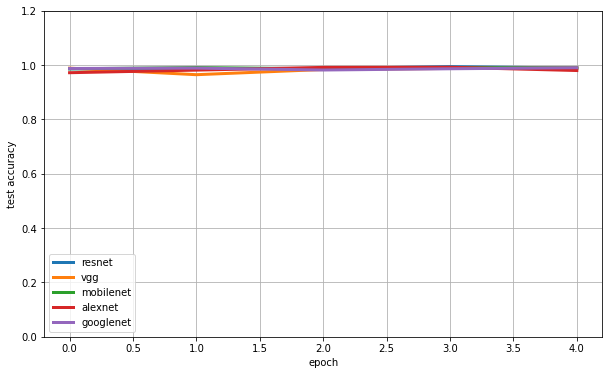

In [13]:
plt.figure(figsize=(10,6))

plt.plot(resnet_history[4], linewidth=3)
plt.plot(googlenet_history[4], linewidth=3)
plt.plot(vgg_history[4], linewidth=3)
plt.plot(mobilenet_history[4], linewidth=3)
plt.plot(alexnet_history[4], linewidth=3)

plt.legend(['resnet', 'vgg', 'mobilenet', 'alexnet', 'googlenet'])

plt.grid()

plt.ylim([0,1.2])

plt.xlabel('epoch')
plt.ylabel('test accuracy')